---
title: "Lab 7: Heart Attack"
format: 
  html:
    theme: lux
---

# Lab 7

# Charles Annis

# Part 1

# Q1: KNN

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import plotnine as p9


ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

X = ha.drop(columns=['output'])
y = ha['output']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.select_dtypes(include=['float64', 'int64']).columns)
    ]
)

knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

knn_grid = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X, y)

best_params_knn = knn_grid.best_params_
print(f"Best Parameters: {best_params_knn}")
best_roc_auc_knn = knn_grid.best_score_
print(f"Cross-Validated ROC AUC: {best_roc_auc_knn}")

best_knn = knn_grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_knn.fit(X_train, y_train)

y_pred_prob_knn = best_knn.predict_proba(X_test)[:, 1]
test_roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)
print(f"Test ROC AUC: {test_roc_auc_knn}")

y_pred_knn = best_knn.predict(X_test)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(f"Confusion Matrix:\n{conf_matrix_knn}")

Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Cross-Validated ROC AUC: 0.8277110521662246
Test ROC AUC: 0.7009283819628647
Confusion Matrix:
[[17  9]
 [11 18]]


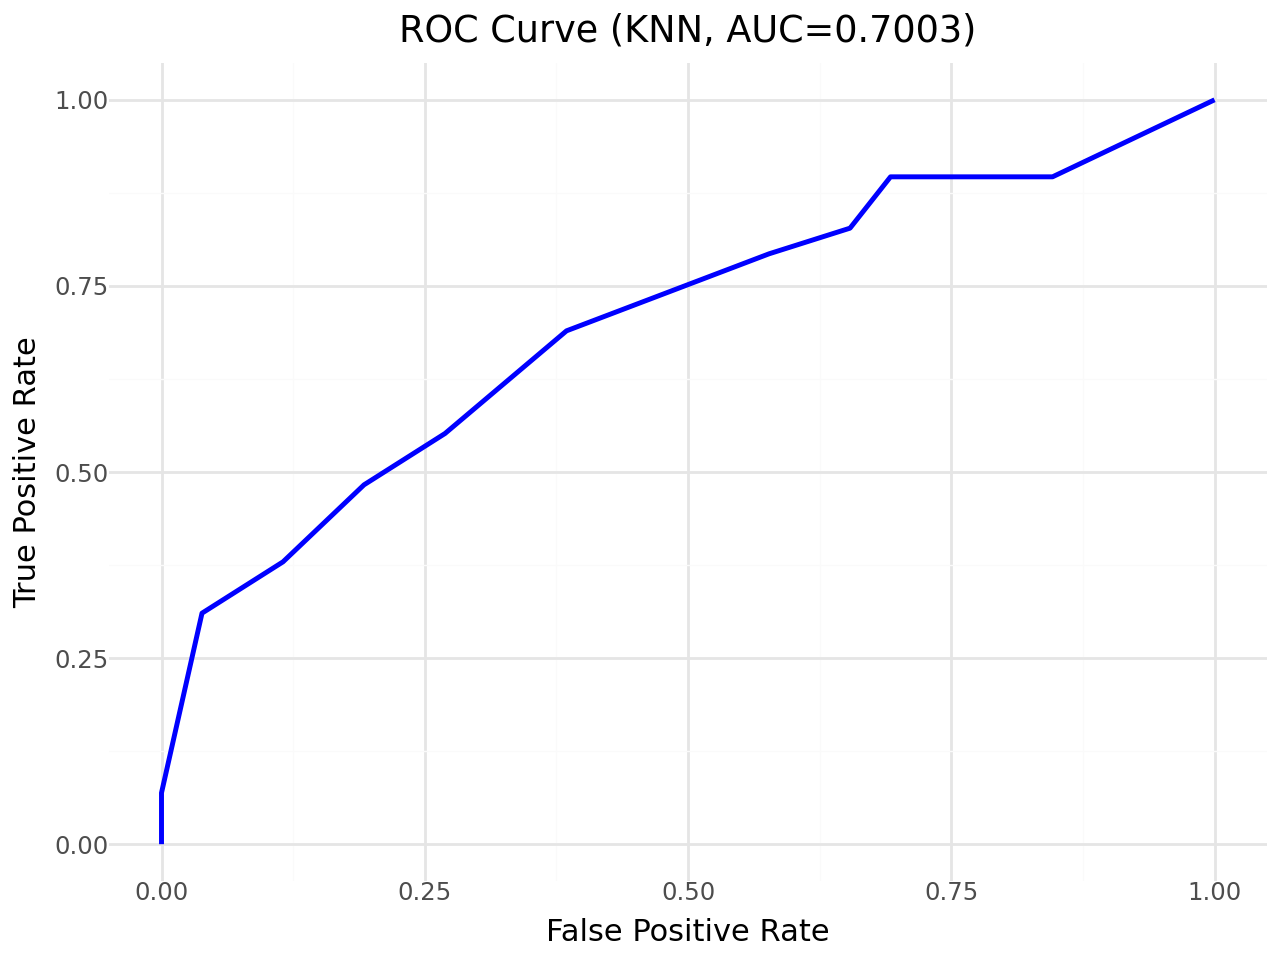

In [ ]:
# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR')) +
    geom_line(color="blue", size=1) +
    labs(title=f'ROC Curve (KNN, AUC={roc_auc:.4f})', x='False Positive Rate', y='True Positive Rate') +
    theme_minimal()
)

roc_plot

# Q2 Logistic Regression

In [ ]:

numerical_features = ['age', 'trtbps', 'chol', 'thalach']
categorical_features = ['sex', 'cp', 'restecg']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

logreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_logreg = grid_search.best_estimator_
best_params = grid_search.best_params_

cv_auc = cross_val_score(best_logreg, X_train, y_train, cv=5, scoring='roc_auc').mean()

best_logreg.fit(X_train, y_train)

y_pred = best_logreg.predict(X_test)
y_prob = best_logreg.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_prob)

print("Best Parameters:", best_params)
print("Cross-Validated ROC AUC:", cv_auc)
print("Test ROC AUC:", roc_auc)

num_features = numerical_features
cat_features = categorical_features

preprocessor_cols = []

preprocessor_cols.extend(num_features)

cat_onehot_cols = best_logreg.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
preprocessor_cols.extend(cat_onehot_cols)

coef_df = pd.DataFrame({
    'Feature': preprocessor_cols,
    'Coefficient': best_logreg.named_steps['logreg'].coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance:\n", coef_df)


cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm_df = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')

conf_matrix_logreg = confusion_matrix(y_test, y_pred)
print(f"Logistic Regression Confusion Matrix:\n{conf_matrix_logreg}")





Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l1'}
Cross-Validated ROC AUC: 0.8958410973084886
Test ROC AUC: 0.7135278514588859
Feature Importance:
       Feature  Coefficient
4       sex_0     2.363084
3     thalach     1.171101
7        cp_1     0.693913
8        cp_2     0.071033
11  restecg_1     0.003825
5       sex_1     0.000000
9        cp_3     0.000000
10  restecg_0     0.000000
12  restecg_2     0.000000
1      trtbps    -0.133615
2        chol    -0.236108
0         age    -0.263438
6        cp_0    -1.767173
Logistic Regression Confusion Matrix:
[[18  8]
 [13 16]]


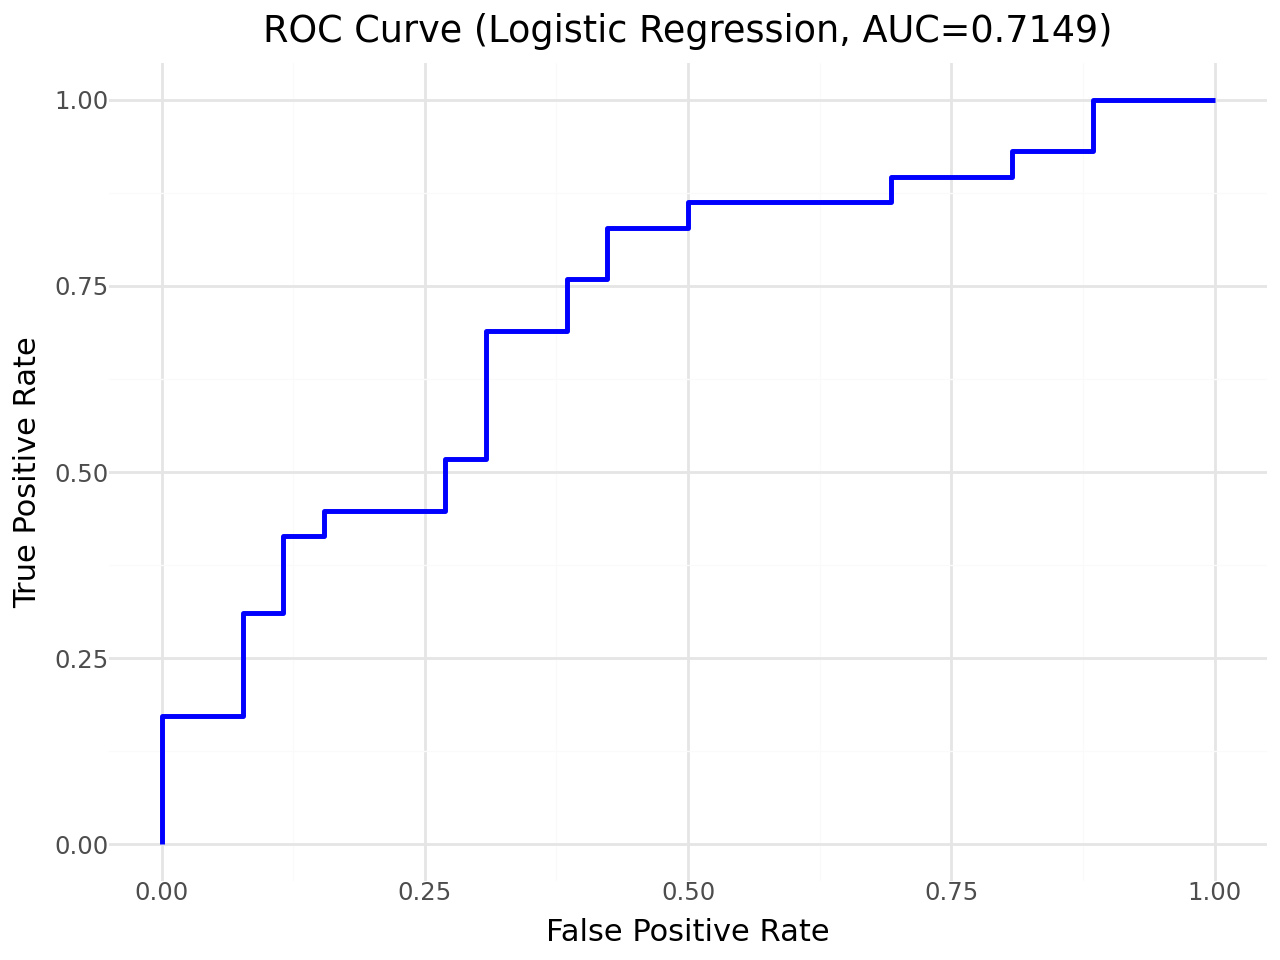

In [ ]:
# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR')) +
    geom_line(color="blue", size=1) +
    labs(title=f'ROC Curve (Logistic Regression, AUC={roc_auc:.4f})', x='False Positive Rate', y='True Positive Rate') +
    theme_minimal()
)

roc_plot

# Q3 Decision Tree

In [ ]:

numerical_features = ['age', 'trtbps', 'chol', 'thalach']
categorical_features = ['sex', 'cp', 'restecg']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'tree__max_depth': [3, 5, 10, 15, 20],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__criterion': ['gini', 'entropy']
}

grid_search_tree = GridSearchCV(tree_pipe, param_grid, cv=5, scoring='roc_auc')
grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_estimator_
best_tree_params = grid_search_tree.best_params_

print("Best Parameters:", best_tree_params)
print("Cross-Validated ROC AUC:", grid_search_tree.best_score_)

y_pred_tree = best_tree.predict(X_test)
roc_auc_test = roc_auc_score(y_test, best_tree.predict_proba(X_test)[:, 1])
print("Test ROC AUC:", roc_auc_test)

conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
print(f"Decision Tree Confusion Matrix:\n{conf_matrix_tree}")



Best Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Cross-Validated ROC AUC: 0.8276695134575569
Test ROC AUC: 0.7241379310344828
Decision Tree Confusion Matrix:
[[17  9]
 [11 18]]


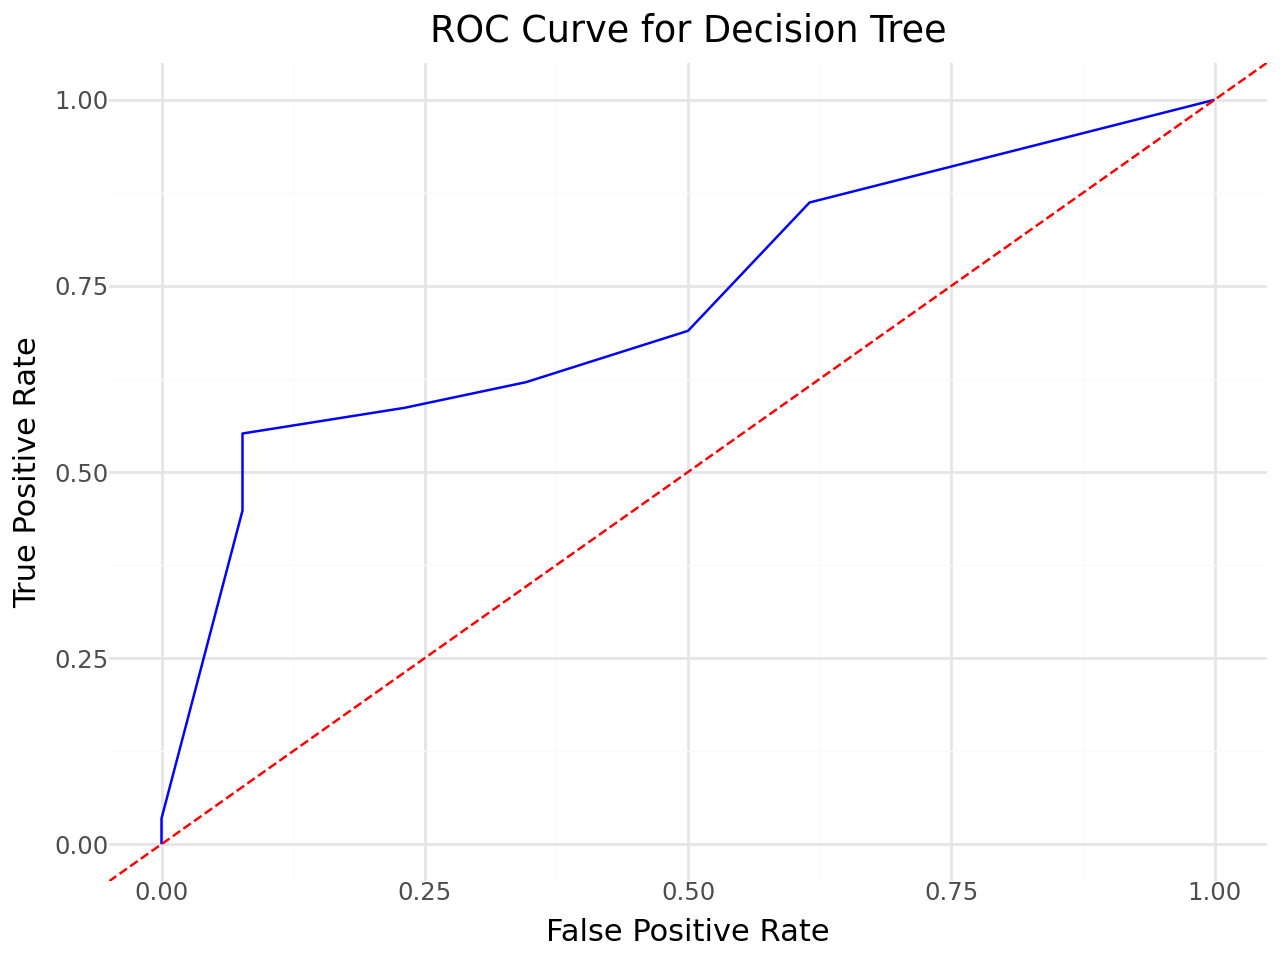

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})

roc_plot = (
    ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='blue') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    theme_minimal() +
    labs(title='ROC Curve for Decision Tree', x='False Positive Rate', y='True Positive Rate')
)

roc_plot


# Q4 Interpretation

Logistic Regression seems like the best candidate for predicting heart attack risk based on these models, but there is room for further improvement, especially in reducing false negatives for heart attack predictions.

# Q5 ROC Curve

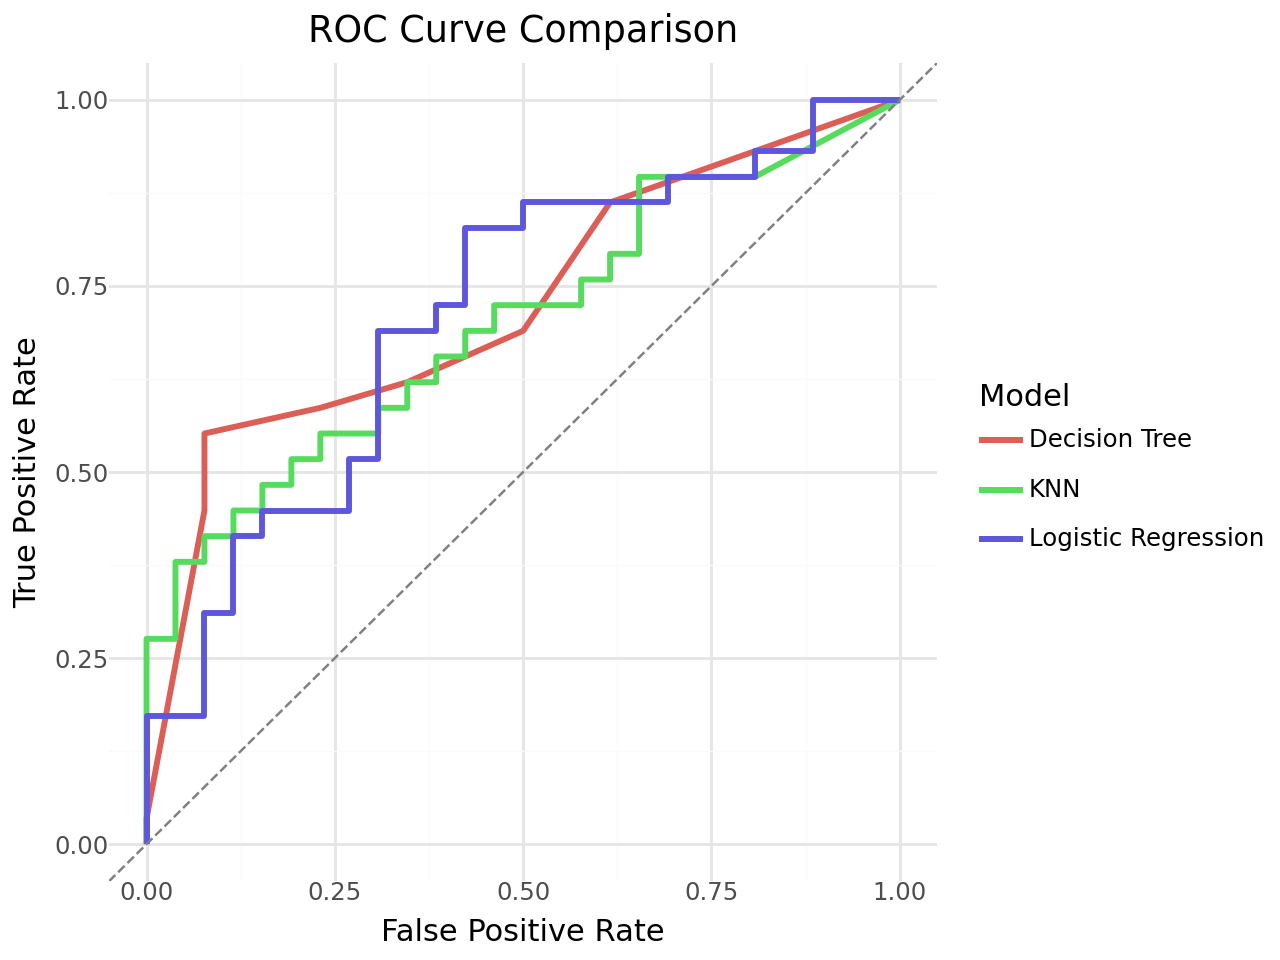

In [ ]:

fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn.predict_proba(X_test)[:, 1])
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, best_logreg.predict_proba(X_test)[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test, best_tree.predict_proba(X_test)[:, 1])

roc_data = pd.DataFrame({
    'False Positive Rate': list(fpr_knn) + list(fpr_logreg) + list(fpr_tree),
    'True Positive Rate': list(tpr_knn) + list(tpr_logreg) + list(tpr_tree),
    'Model': ['KNN'] * len(fpr_knn) + ['Logistic Regression'] * len(fpr_logreg) + ['Decision Tree'] * len(fpr_tree)
})

roc_plot = (ggplot(roc_data, p9.aes(x='False Positive Rate', y='True Positive Rate', color='Model'))
            + geom_line(size=1.2)
            + geom_abline(slope=1, intercept=0, linetype='--', color='gray')
            + labs(title='ROC Curve Comparison', x='False Positive Rate', y='True Positive Rate')
            + theme_minimal())

roc_plot


# Part Two

In [40]:

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # True Positive Rate (Recall/Sensitivity)
    TPR = TP / (TP + FN)

    # Precision
    Precision = TP / (TP + FP)

    # True Negative Rate (Specificity)
    TNR = TN / (TN + FP)

    return TPR, Precision, TNR

models = {'KNN': best_knn, 'Logistic Regression': best_logreg, 'Decision Tree': best_tree}

metrics_data = []

for model_name, model in models.items():

    y_pred = cross_val_predict(model, X_train, y_train, cv=5)

    TPR, Precision, TNR = compute_metrics(y_train, y_pred)

    metrics_data.append({
        'Model': model_name,
        'True Positive Rate (Recall)': TPR,
        'Precision': Precision,
        'True Negative Rate (Specificity)': TNR
    })

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)


                 Model  True Positive Rate (Recall)  Precision  \
0                  KNN                     0.811966   0.778689   
1  Logistic Regression                     0.846154   0.811475   
2        Decision Tree                     0.743590   0.805556   

   True Negative Rate (Specificity)  
0                          0.732673  
1                          0.772277  
2                          0.792079  


# Part 3

### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

**Metric(s) to use**: **True Positive Rate (Recall)**. This metric is crucial because it measures how well the model identifies true positives (patients who actually have a heart attack). A high recall ensures that the hospital minimizes the risk of missing high-risk patients, reducing potential lawsuits.

**Recommended Model**: **Logistic Regression**. It has the highest recall (0.85) among the models, meaning it is better at identifying high-risk patients.

**Expected Score**: You can expect a recall score close to **0.85** for Logistic Regression, indicating that it will catch most of the high-risk patients.

### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

**Metric(s) to use**: **Precision**. Precision tells us how many of the patients the model predicts as high-risk truly are high-risk. The hospital wants to avoid using resources on patients who don't actually need monitoring, so a high precision is important.

**Recommended Model**: **Decision Tree**. It has a good precision (0.81) while maintaining reasonable specificity.

**Expected Score**: You can expect a precision score of around **0.81**, meaning that most of the patients flagged by the model as high-risk are actually high-risk.

### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

**Metric(s) to use**: **Feature Importance**. For understanding the biological factors driving heart attack risk, examining feature importance (like coefficients in logistic regression or splits in decision trees) is key. This tells us which features are most influential in predicting the outcome.

**Recommended Model**: **Logistic Regression**. It provides clear coefficients that show the influence of each feature, which is helpful for interpreting the biological measures linked to heart attack risk.

**Expected Score**: Expect a **0.71 ROC AUC score**, which is solid for a model used for interpretation, with reasonably good predictive power.

### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

**Metric(s) to use**: **Confusion Matrix (TP, FP, TN, FN)**. This allows the hospital to compare the predictions of doctors (i.e., whether they classify patients as high-risk or not) to the algorithm’s predictions, showing how well the doctors perform in identifying heart attack risk compared to the model.

**Recommended Model**: **KNN**. KNN has a balanced recall (0.81) and precision (0.77), making it useful for comparing both false positives and false negatives against doctor diagnoses.

**Expected Score**: You should expect the confusion matrix to show a relatively balanced performance, with a recall around **0.81** and precision around **0.77**, which reflects good diagnostic ability.

In [43]:

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

X_validation = ha_validation.drop(columns=['output'])
y_validation = ha_validation['output']

y_pred_knn = best_knn.predict(X_validation)
y_pred_proba_knn = best_knn.predict_proba(X_validation)[:, 1]

conf_matrix_knn = confusion_matrix(y_validation, y_pred_knn)
roc_auc_knn = roc_auc_score(y_validation, y_pred_proba_knn)
precision_knn = precision_score(y_validation, y_pred_knn)
recall_knn = recall_score(y_validation, y_pred_knn)

print("KNN Confusion Matrix:")
print(conf_matrix_knn)
print(f"KNN ROC AUC: {roc_auc_knn}")
print(f"KNN Precision: {precision_knn}")
print(f"KNN Recall: {recall_knn}")


KNN Confusion Matrix:
[[10  1]
 [ 6 13]]
KNN ROC AUC: 0.8899521531100478
KNN Precision: 0.9285714285714286
KNN Recall: 0.6842105263157895


In [44]:

X_validation = ha_validation.drop(columns=['output'])
y_validation = ha_validation['output']

y_pred_logreg = best_logreg.predict(X_validation)
y_pred_proba_logreg = best_logreg.predict_proba(X_validation)[:, 1]

conf_matrix_logreg = confusion_matrix(y_validation, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_validation, y_pred_proba_logreg)
precision_logreg = precision_score(y_validation, y_pred_logreg)
recall_logreg = recall_score(y_validation, y_pred_logreg)

print("Logistic Regression Confusion Matrix:")
print(conf_matrix_logreg)
print(f"Logistic Regression ROC AUC: {roc_auc_logreg}")
print(f"Logistic Regression Precision: {precision_logreg}")
print(f"Logistic Regression Recall: {recall_logreg}")


Logistic Regression Confusion Matrix:
[[ 8  3]
 [ 6 13]]
Logistic Regression ROC AUC: 0.8516746411483254
Logistic Regression Precision: 0.8125
Logistic Regression Recall: 0.6842105263157895


In [45]:

y_pred_tree = best_tree.predict(X_validation)
y_pred_proba_tree = best_tree.predict_proba(X_validation)[:, 1]

conf_matrix_tree = confusion_matrix(y_validation, y_pred_tree)
roc_auc_tree = roc_auc_score(y_validation, y_pred_proba_tree)
precision_tree = precision_score(y_validation, y_pred_tree)
recall_tree = recall_score(y_validation, y_pred_tree)

print("Decision Tree Confusion Matrix:")
print(conf_matrix_tree)
print(f"Decision Tree ROC AUC: {roc_auc_tree}")
print(f"Decision Tree Precision: {precision_tree}")
print(f"Decision Tree Recall: {recall_tree}")


Decision Tree Confusion Matrix:
[[ 8  3]
 [ 6 13]]
Decision Tree ROC AUC: 0.7583732057416267
Decision Tree Precision: 0.8125
Decision Tree Recall: 0.6842105263157895


The cross-validation results were pretty close to what we saw on the validation set, with some expected differences. The recall stayed about the same for all the models, but the ROC AUC scores changed more, especially for the Decision Tree, which might have overfitted.

# Part 5

In [49]:

# KNN Confusion Matrix
knn_pred = best_knn.predict(X_val)
knn_cm = confusion_matrix(y_val, knn_pred)
# Logistic Regression Confusion Matrix
logreg_pred = best_logreg.predict(X_val)
logreg_cm = confusion_matrix(y_val, logreg_pred)
# Decision Tree Confusion Matrix
tree_pred = best_tree.predict(X_val)
tree_cm = confusion_matrix(y_val, tree_pred)

kappa_knn = cohen_kappa_score(y_val, knn_pred)
kappa_logreg = cohen_kappa_score(y_val, logreg_pred)
kappa_tree = cohen_kappa_score(y_val, tree_pred)

print(f"KNN Cohen's Kappa: {kappa_knn}")
print(f"Logistic Regression Cohen's Kappa: {kappa_logreg}")
print(f"Decision Tree Cohen's Kappa: {kappa_tree}")


KNN Cohen's Kappa: 0.5414847161572052
Logistic Regression Cohen's Kappa: 0.38914027149321273
Decision Tree Cohen's Kappa: 0.38914027149321273


Cohen’s Kappa is useful when we want to measure how much agreement there is between our model’s predictions and the actual outcomes, beyond just random chance. If we use Kappa, it’s good for dealing with class imbalances, as it adjusts for that. After looking at Kappa, my conclusions don’t change much, but it does show that KNN performs better than Logistic Regression and Decision Tree, as KNN has the highest Kappa score. This makes sense because Kappa gives a clearer picture of agreement, especially when class imbalance might affect accuracy.

Some code provided by ChatGPT